In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.8.0


In [3]:
keras = tf.keras
layers = tf.keras.layers

In [4]:
train_image_path = glob.glob('dog/train/*/*.jpg')

In [5]:
len(train_image_path)

367

In [6]:
train_image_path[290:300]

['dog/train\\healthy\\ia_100011574.jpg',
 'dog/train\\healthy\\ia_100011581.jpg',
 'dog/train\\healthy\\ia_100011582.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_107.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_108.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_125.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_19.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_26.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_30.jpg',
 'dog/train\\unhealthy\\french_bulldog_google_31.jpg']

In [7]:
train_image_path[-5:]

['dog/train\\unhealthy\\ia_100009834.jpg',
 'dog/train\\unhealthy\\ia_100010146.jpg',
 'dog/train\\unhealthy\\ia_100011148.jpg',
 'dog/train\\unhealthy\\ia_100011313.jpg',
 'dog/train\\unhealthy\\ia_100011584.jpg']

In [8]:
train_image_label = [int(path.split('\\')[1] == 'healthy') for path in train_image_path]

In [9]:
train_image_label[:5]

[1, 1, 1, 1, 1]

In [10]:
train_image_label[-5:]

[0, 0, 0, 0, 0]

In [11]:
def load_preprosess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32)
    image = image/255
    #label = tf.reshape(label, [1])
    return image, label

In [12]:
train_image_ds = tf.data.Dataset.from_tensor_slices((train_image_path, train_image_label))

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [14]:
train_image_ds = train_image_ds.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)

In [15]:
train_image_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

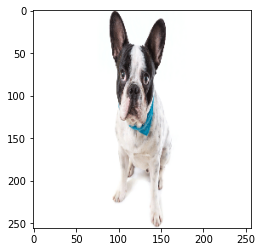

In [16]:
for img, label in train_image_ds.take(2):
    plt.imshow(img)

In [17]:
BATCH_SIZE = 32
train_count = len(train_image_path)

In [18]:
train_image_ds = train_image_ds.shuffle(train_count).repeat().batch(BATCH_SIZE)

In [19]:
test_image_path = glob.glob('dog/test/*/*.jpg')
test_image_label = [int(path.split('\\')[1] == 'healthy') for path in test_image_path]
test_image_ds = tf.data.Dataset.from_tensor_slices((test_image_path, test_image_label))
test_image_ds = test_image_ds.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)
test_image_ds = test_image_ds.repeat().batch(BATCH_SIZE)

In [20]:
test_count = len(test_image_path)
test_count

95

In [21]:
covn_base = tf.keras.applications.VGG16(weights='imagenet', 
                                        include_top=False)                                       

In [22]:
covn_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [23]:
model = keras.Sequential()
model.add(covn_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,977,857
Trainable params: 14,977,857
Non-trainable params: 0
_________________________________________________________________


In [25]:
covn_base.trainable = False

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,977,857
Trainable params: 263,169
Non-trainable params: 14,714,688
_________________________________________________________________


In [27]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.0005),
              loss='binary_crossentropy',
              metrics=['acc'])

C:\Users\Administrator\miniconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
history = model.fit(
    train_image_ds,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=15,
    validation_data=test_image_ds,
    validation_steps=test_count//BATCH_SIZE)

Epoch 1/15
11/11 [==============================] - 139s 13s/step - loss: 0.6114 - acc: 0.7500 - val_loss: 0.0992 - val_acc: 1.0000
Epoch 2/15
11/11 [==============================] - 137s 13s/step - loss: 0.5057 - acc: 0.8040 - val_loss: 0.3334 - val_acc: 1.0000
Epoch 3/15
11/11 [==============================] - 137s 13s/step - loss: 0.5038 - acc: 0.7898 - val_loss: 0.1867 - val_acc: 1.0000
Epoch 4/15
11/11 [==============================] - 136s 13s/step - loss: 0.4813 - acc: 0.8068 - val_loss: 0.2131 - val_acc: 1.0000
Epoch 5/15
11/11 [==============================] - 137s 13s/step - loss: 0.4984 - acc: 0.7926 - val_loss: 0.2341 - val_acc: 1.0000
Epoch 6/15
11/11 [==============================] - 139s 13s/step - loss: 0.4795 - acc: 0.8040 - val_loss: 0.2298 - val_acc: 1.0000
Epoch 7/15
11/11 [==============================] - 137s 13s/step - loss: 0.4805 - acc: 0.8068 - val_loss: 0.1888 - val_acc: 1.0000
Epoch 8/15
11/11 [==============================] - 136s 13s/step - loss: 0.

In [29]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

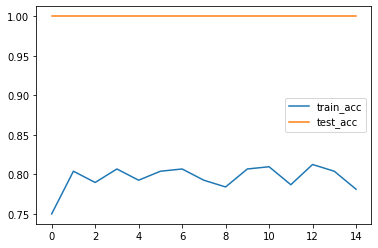

In [32]:
plt.plot(history.epoch, history.history.get('acc'), label='train_acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='test_acc')
plt.legend()

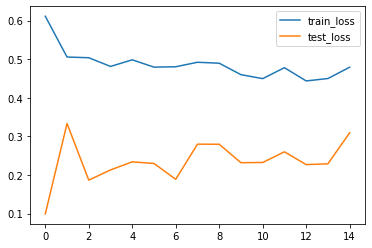

In [33]:
plt.plot(history.epoch, history.history.get('loss'), label='train_loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='test_loss')
plt.legend()

In [45]:
covn_base.trainable = True

In [46]:
len(covn_base.layers)

19

In [47]:
fine_tune_at = -3

In [48]:
for layer in covn_base.layers[:fine_tune_at]:
    layer.trainable =  False

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,977,857
Trainable params: 4,982,785
Non-trainable params: 9,995,072
_________________________________________________________________


In [50]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=0.0005/10),
              metrics=['accuracy'])

In [39]:
initial_epochs = 15
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs


history = model.fit(
    train_image_ds,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch = initial_epochs,
    validation_data=test_image_ds,
    validation_steps=test_count//BATCH_SIZE)

Epoch 16/25
11/11 [==============================] - 164s 15s/step - loss: 0.4587 - accuracy: 0.8097 - val_loss: 0.1547 - val_accuracy: 1.0000
Epoch 17/25
11/11 [==============================] - 178s 16s/step - loss: 0.4478 - accuracy: 0.8068 - val_loss: 0.3483 - val_accuracy: 0.9531
Epoch 18/25
11/11 [==============================] - 165s 15s/step - loss: 0.3826 - accuracy: 0.8239 - val_loss: 0.3441 - val_accuracy: 0.9531
Epoch 19/25
11/11 [==============================] - 153s 14s/step - loss: 0.3608 - accuracy: 0.8352 - val_loss: 0.2556 - val_accuracy: 0.9688
Epoch 20/25
11/11 [==============================] - 153s 14s/step - loss: 0.3267 - accuracy: 0.8381 - val_loss: 0.2958 - val_accuracy: 0.9531
Epoch 21/25
11/11 [==============================] - 165s 15s/step - loss: 0.2886 - accuracy: 0.8892 - val_loss: 0.1216 - val_accuracy: 0.9844
Epoch 22/25
11/11 [==============================] - 170s 16s/step - loss: 0.2896 - accuracy: 0.8722 - val_loss: 0.2937 - val_accuracy: 0.9531

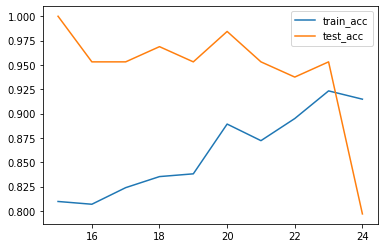

In [54]:
plt.plot(history.epoch, history.history.get('accuracy'), label='train_acc')
plt.plot(history.epoch, history.history.get('val_accuracy'), label='test_acc')
plt.legend()

In [53]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

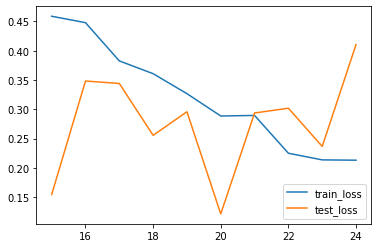

In [52]:
plt.plot(history.epoch, history.history.get('loss'), label='train_loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='test_loss')
plt.legend()